# Final project
#### Plant disease detection --> multiclassification problem

1. Install the packages

In [1]:
# Dowload the packages
!pip install split-folders

In [2]:
# Dowload the packages
import numpy as np
import pandas as pd
import os,os.path
import splitfolders
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, MobileNet, VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
# Set some default variables
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
BATCH_SIZE = 40
EPOCHS = 5
IMAGE_SHAPE = (224, 224)

2. Upload and explore the data

In [4]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)
    
    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))
    
    pairs.append(columns)
    
pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

Plant                               Disease  \
27                    Apple                               healthy   
20                    Apple                      Cedar_apple_rust   
16                    Apple                             Black_rot   
13                    Apple                            Apple_scab   
17                Blueberry                               healthy   
18  Cherry_(including_sour)                        Powdery_mildew   
30  Cherry_(including_sour)                               healthy   
31             Corn_(maize)                          Common_rust_   
10             Corn_(maize)   Cercospora_leaf_spot Gray_leaf_spot   
37             Corn_(maize)                               healthy   
7              Corn_(maize)                  Northern_Leaf_Blight   
23                    Grape    Leaf_blight_(Isariopsis_Leaf_Spot)   
28                    Grape                             Black_rot   
32                    Grape                  Esca_(Black_Measles)   
2                     Grape                               healthy   
3                    Orange       Haunglongbing_(Citrus_greening)   
19                    Peach                        Bacterial_spot   
12                    Peach                               healthy   
36             Pepper,_bell                        Bacterial_spot   
22             Pepper,_bell                               healthy   
6                    Potato                               healthy   
29                   Potato                          Early_blight   
24                   Potato                           Late_blight   
33                Raspberry                               healthy   
4                   Soybean                               healthy   
5                    Squash                        Powdery_mildew   
26               Strawberry                               healthy   
11               Strawberry                           Leaf_scorch   
34                   Tomato                             Leaf_Mold   
1                    Tomato                               healthy   
35                   Tomato  Spider_mites Two-spotted_spider_mite   
8                    Tomato                          Early_blight   
9                    Tomato                    Septoria_leaf_spot   
21                   Tomato                           Target_Spot   
15                   Tomato                        Bacterial_spot   
14                   Tomato         Tomato_Yellow_Leaf_Curl_Virus   
25                   Tomato                   Tomato_mosaic_virus   
0                    Tomato                           Late_blight   

                                            Directory  Files  
27                                    Apple___healthy   1645  
20                           Apple___Cedar_apple_rust    275  
16                                  Apple___Black_rot    621  
13                                 Apple___Apple_scab    630  
17                                Blueberry___healthy   1502  
18           Cherry_(including_sour)___Powdery_mildew   1052  
30                  Cherry_(including_sour)___healthy    854  
31                        Corn_(maize)___Common_rust_   1192  
10  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...    513  
37                             Corn_(maize)___healthy   1162  
7                 Corn_(maize)___Northern_Leaf_Blight    985  
23         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   1076  
28                                  Grape___Black_rot   1180  
32                       Grape___Esca_(Black_Measles)   1383  
2                                     Grape___healthy    423  
3            Orange___Haunglongbing_(Citrus_greening)   5507  
19                             Peach___Bacterial_spot   2297  
12                                    Peach___healthy    360  
36                      Pepper,_bell___Bacterial_spot    997  
22                             Pepper,_bell___healthy   1478  
6      

There are some pairs when only a healthy plant is present. These are Blueberry (17), Orange (3), Raspberry (33), Soybean (4), Squash (5). These are not exactly interesting for us, because we want to detect diseases. Therefore, we will delete these observations in the future. 

In [5]:
# Save the directories to be deleted
rows_to_drop = [17, 3, 33, 4, 5]
dir_to_delete = pairs[pairs.index.isin(rows_to_drop)]['Directory']
print(dir_to_delete.values)

['Orange___Haunglongbing_(Citrus_greening)' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Blueberry___healthy' 'Raspberry___healthy']


In [6]:
# Drop the rows we don't need from the dataframe
pairs = pairs[~pairs.index.isin(rows_to_drop)]

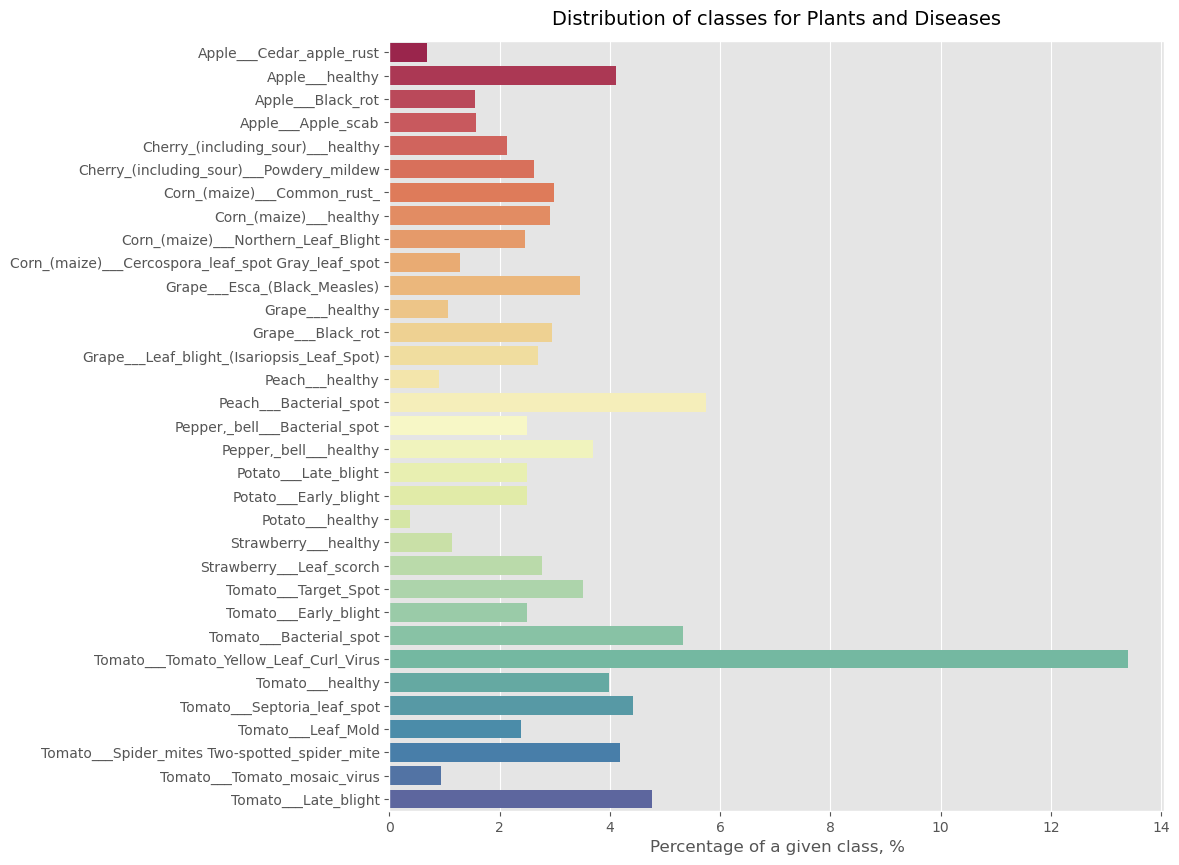

In [7]:
# Save the sorted dataframe
pairs_pie = pairs.sort_values(by='Plant')

# Create a pie-chart to check class balance
data = pairs_pie['Files'].values / sum(pairs_pie['Files']) * 100
labels = pairs_pie['Directory'].values
colors = sns.color_palette("Spectral", 33)

plt.figure(figsize=(10,10))
plt.title("Distribution of classes for Plants and Diseases", loc='center', y=1.01, fontsize=14)
plt.xlabel("Percentage of a given class, %")

sns.barplot(x=data, y=labels, orient='h', palette=colors)

#plt.pie(data, colors = colors, labels=labels, textprops={'fontsize': 5},  labeldistance=1.2)
#plt.pie(data, colors = colors, autopct='%d%%', textprops={'fontsize': 7})
#plt.legend(labels, bbox_to_anchor=(1, 1), fontsize=5)

plt.show()

In [8]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [9]:
# Split the data into folders
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 54305 files [07:34, 119.36 files/s]


In [10]:
# Remove the directories we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]

for sub_directory in dir_to_delete.values:
    for directory in PATHS:
        d = directory + '/' + sub_directory
        shutil.rmtree(d)

In [11]:
# Generate batches of tensor image data

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          shuffle = False)

Found 31987 images belonging to 33 classes.
Found 3988 images belonging to 33 classes.
Found 4025 images belonging to 33 classes.


Image dimensions: (256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

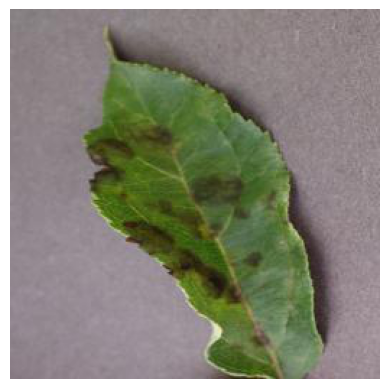

In [12]:
# Check one example
example = './images/val/Apple___Apple_scab/8632c6b9-84e1-4779-9294-71548ff838e5___FREC_Scab 3423.JPG'

image = mpimg.imread(example)

# Print out the image dimensions
print('Image dimensions:', image.shape)
plt.imshow(image)
plt.axis("off")

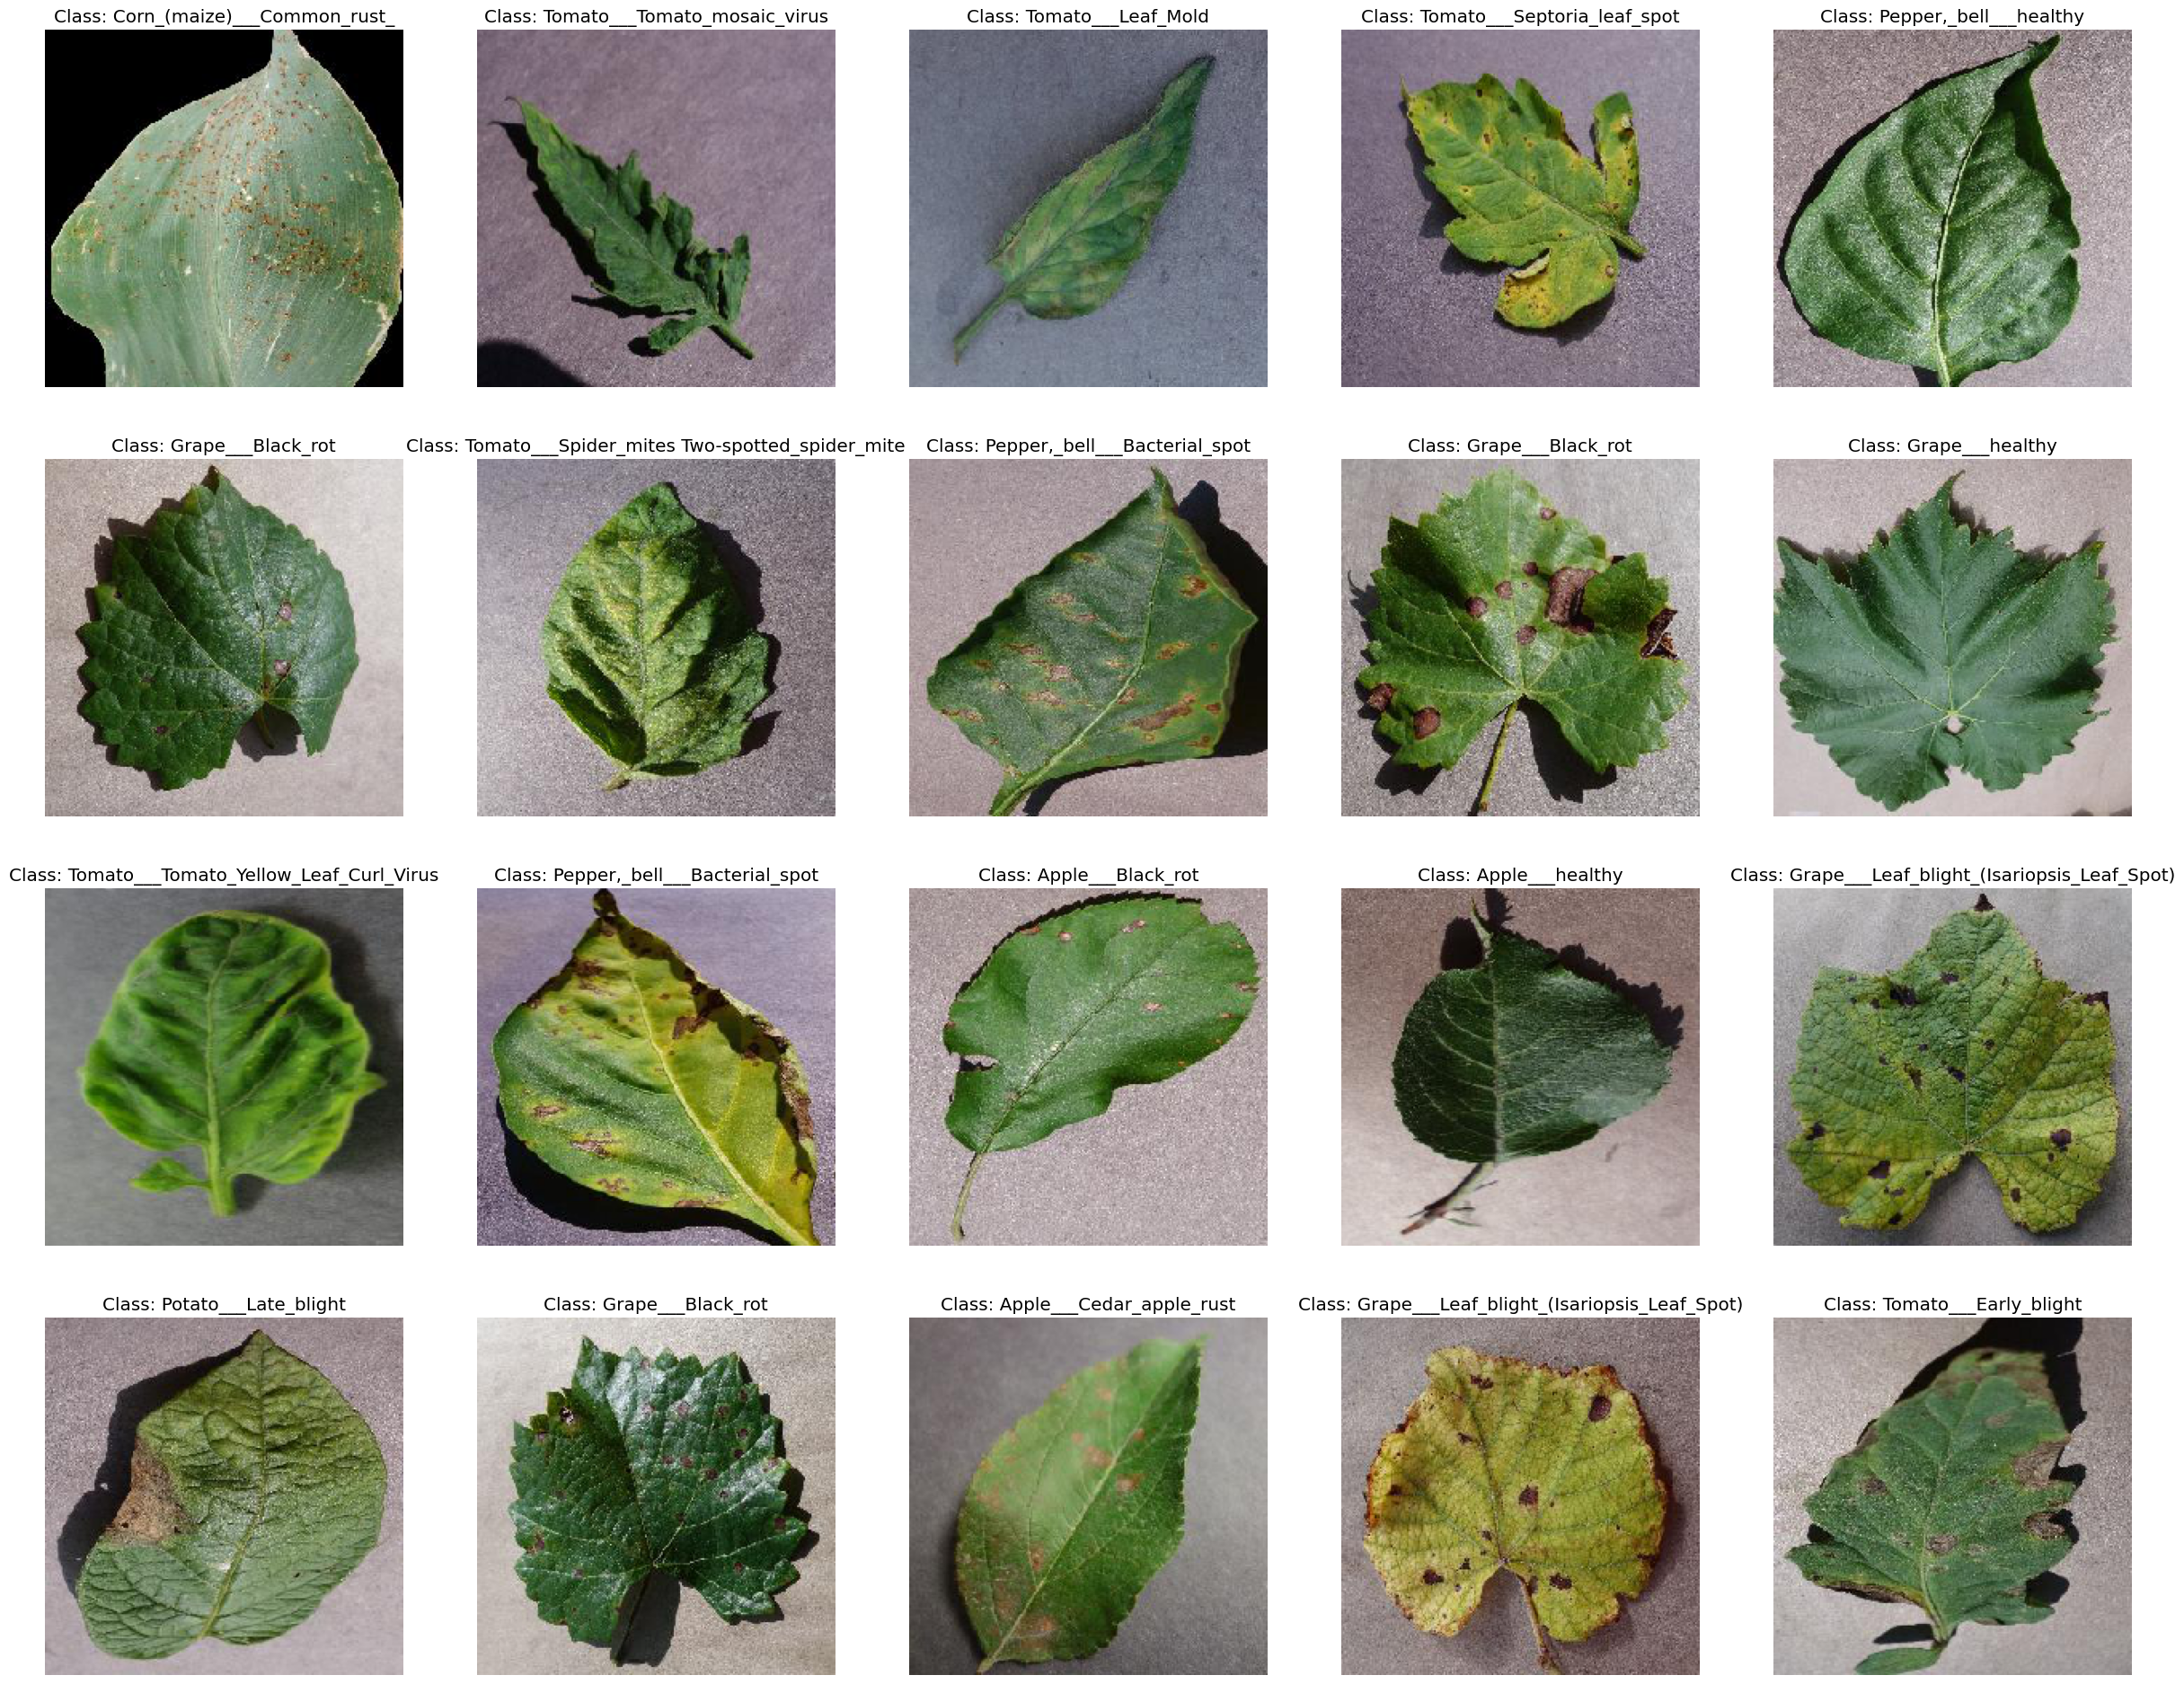

In [13]:
# Check some more images

# Collect the labels
labels = [l for l in train_gen.class_indices]
# Take the next batch out of train_generator
samples = next(train_gen)
# Store info on pixels of each image in images
images = samples[0]
# Store info on the class in titles
titles = samples[1]

# Set figure size
plt.figure(figsize=(30,30))

# Create subplots
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")